## FCNN Fault Prediction

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import segyio

In [3]:
# Note: the the xline header info location is at segyio.su.cdpx [181]
def segy2numpy(filename: str) -> np.array:
    with segyio.open(filename, xline=181) as segyfile:
        return segyio.tools.cube(segyfile)


In [4]:
# 2. **Dataset Preparation**
class SeismicDataset(Dataset):
    def __init__(self, seismic, fault):
        self.seismic = seismic
        self.fault = fault

    def __len__(self):
        return self.seismic.shape[0]

    def __getitem__(self, idx):
        seismic_sample = torch.tensor(self.seismic[idx], dtype=torch.float32).unsqueeze(0)
        fault_sample = torch.tensor(self.fault[idx], dtype=torch.float32).unsqueeze(0)
        return seismic_sample, fault_sample

In [5]:
# 3. **FCNN Architecture**
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [6]:
def train_fcnn(model, dataloader, optimizer, criterion, device, n_epochs=20):
    model.train()
    train_losses = []

    for epoch in range(n_epochs):
        epoch_loss = 0.0

        for seismic_batch, fault_batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
            seismic_batch, fault_batch = seismic_batch.to(device), fault_batch.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = model(seismic_batch)

            # Match shapes by cropping or padding
            if outputs.shape != fault_batch.shape:
                diff_h = outputs.shape[2] - fault_batch.shape[2]
                diff_w = outputs.shape[3] - fault_batch.shape[3]

                if diff_h > 0 or diff_w > 0:
                    fault_batch = nn.functional.pad(
                        fault_batch, (0, diff_w, 0, diff_h)
                    )  # Pad width (left, right), height (top, bottom)
                elif diff_h < 0 or diff_w < 0:
                    fault_batch = fault_batch[:, :, : outputs.shape[2], : outputs.shape[3]]  # Crop

            # Compute loss
            loss = criterion(outputs, fault_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")

    return train_losses


In [7]:
# 5. **Visualization Functions**
def visualize_data(seismic, fault, predictions=None, idx=0):
    """
    Visualize seismic data, ground truth faults, and predictions (if available).
    """
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Seismic Data")
    plt.imshow(seismic[idx], cmap="seismic")
    plt.subplot(1, 3, 2)
    plt.title("Fault Ground Truth")
    plt.imshow(fault[idx], cmap="gray")
    if predictions is not None:
        plt.subplot(1, 3, 3)
        plt.title("Predicted Fault")
        plt.imshow(predictions[idx], cmap="gray")
    plt.show()

In [11]:
def evaluate_model(model, dataloader, device):
    """
    Evaluates the model on the provided dataloader.
    Parameters:
        model: The trained model to evaluate.
        dataloader: DataLoader containing the validation/test data.
        device: Device to perform computation on ('cuda' or 'cpu').
    Returns:
        A numpy array containing all predictions.
    """
    model.eval()
    all_predictions = []
    
    with torch.no_grad():
        for seismic_batch, _ in dataloader:
            seismic_batch = seismic_batch.to(device)
            
            # Generate predictions
            outputs = model(seismic_batch)
            
            # Ensure outputs are in the correct shape
            outputs = outputs.squeeze().cpu().numpy()
            
            # Add a batch dimension if missing
            if outputs.ndim == 2:
                outputs = outputs[np.newaxis, ...]
            
            all_predictions.append(outputs)
    
    # Concatenate all predictions along the batch axis
    return np.concatenate(all_predictions, axis=0)

## Prepare for modelling

In [9]:
# First load datasets
filename_pp = "C:\\Users\\hsk21\\Desktop\\MLcourse\\github\\Seismic-Fault-Detection-using-Convolutional-Neural-Network\\Equinor Synthetic model\\Equinor Synthetic model\\issap20_Pp.sgy"
filename_ai = "C:\\Users\\hsk21\\Desktop\\MLcourse\\github\\Seismic-Fault-Detection-using-Convolutional-Neural-Network\\Equinor Synthetic model\\Equinor Synthetic model\\issap20_Fault.sgy"
filename_fault = "C:\\Users\\hsk21\\Desktop\\MLcourse\\github\\Seismic-Fault-Detection-using-Convolutional-Neural-Network\\Equinor Synthetic model\\Equinor Synthetic model\\issap20_Fault.sgy"


In [ ]:
seismic= segy2numpy(filename_pp)
faults = segy2numpy(filename_fault)
# Train-test split
seismic_train, seismic_val, fault_train, fault_val = train_test_split(seismic, faults, test_size=0.2, random_state=42)

# Datasets and Dataloaders
train_dataset = SeismicDataset(seismic_train, fault_train)
val_dataset = SeismicDataset(seismic_val, fault_val)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Model, Loss, Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FCNN().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
print("Training...")
train_losses = train_fcnn(model, train_loader, optimizer, criterion, device, n_epochs=20)



Training...


Epoch 1/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 0.2781


Epoch 2/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2/20 - Loss: 0.0850


Epoch 3/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3/20 - Loss: 0.0761


Epoch 4/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 4/20 - Loss: 0.0748


Epoch 5/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 5/20 - Loss: 0.0745


Epoch 6/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 6/20 - Loss: 0.0742


Epoch 7/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 7/20 - Loss: 0.0739


Epoch 8/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 8/20 - Loss: 0.0737


Epoch 9/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 9/20 - Loss: 0.0733


Epoch 10/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 10/20 - Loss: 0.0726


Epoch 11/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 11/20 - Loss: 0.0717


Epoch 12/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 12/20 - Loss: 0.0697


Epoch 13/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 13/20 - Loss: 0.0657


Epoch 14/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 14/20 - Loss: 0.0617


Epoch 15/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 15/20 - Loss: 0.0591


Epoch 16/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 16/20 - Loss: 0.0589


Epoch 17/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 17/20 - Loss: 0.0562


Epoch 18/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 18/20 - Loss: 0.0528


Epoch 19/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 19/20 - Loss: 0.0506


Epoch 20/20:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 20/20 - Loss: 0.0502
Evaluating...


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 5 has 2 dimension(s)

Evaluating...
Visualizing Results...


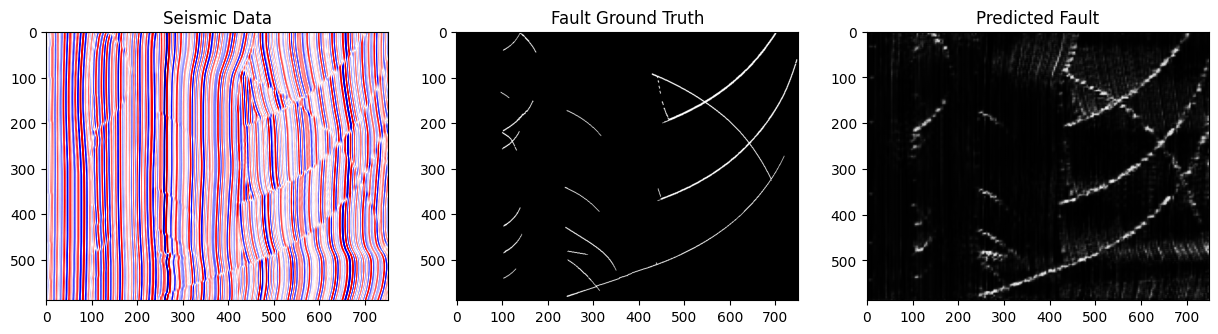

In [12]:
# Evaluate the model
print("Evaluating...")
predictions = evaluate_model(model, val_loader, device)

# Visualization
print("Visualizing Results...")
visualize_data(seismic_val, fault_val, predictions)